# Assignment 1: GAN

#### Student Name: Francis Kurian

In this assignment, you will create a GAN Model to generate the MNIST handwritten numbers.


In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot

In [2]:
import tensorflow.keras as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.datasets.cifar10 import load_data

## Load the dataset

In [3]:
from keras.datasets.mnist import load_data
(trainX, trainy), (testX, testy) = load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

11490434/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


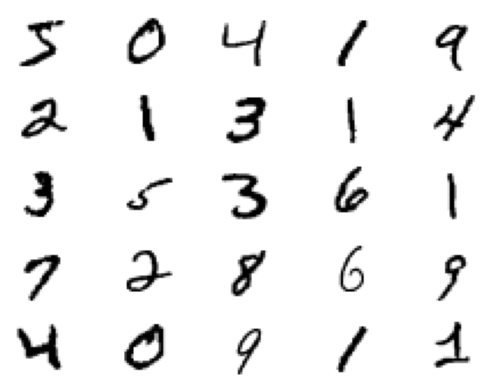

In [4]:
from matplotlib import pyplot

for i in range(25):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [5]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

## Generate Real and Fake Samples

In [6]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y


In [7]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

## Define the generator


In [8]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))

    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model


In [9]:
define_generator(28).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              181888    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       262272    
 Transpose)                                             

## Define the discriminator

In [10]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = K.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)  # Change lr to learning_rate
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [11]:
define_discriminator().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)             

## Combine and Train the model
combine the generator and the discriminator model, for training the generator:

In [12]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = K.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)  # Use learning_rate instead of lr
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


## Train the Model

In [13]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    g_model.compiled_metrics==None
    d_model.compiled_metrics==None
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            g_model.compiled_metrics == None
            d_model.compiled_metrics == None
            X_real, y_real = generate_real_samples(dataset, 100)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 100)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            # print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
            # evaluate the model performance, sometimes
        if (i+1) % 1 == 0:
          summarize_performance(i, g_model, d_model, dataset, latent_dim)

## Evaluate and Visualize the progress

In [14]:
def save_plot(examples, epoch, n=10):
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()



In [15]:
latent_dim = 10
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 0s 16ms/step
>Accuracy real: 40%, fake: 55%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 16ms/step
>Accuracy real: 31%, fake: 86%


4/4 [==============================] - 0s 17ms/step
>Accuracy real: 51%, fake: 61%


4/4 [==============================] - 0s 16ms/step
>Accuracy real: 69%, fake: 66%


4/4 [==============================] - 0s 15ms/step
>Accuracy real: 64%, fake: 77%


## Generate Sample Random Numbers

In [23]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

model = load_model('generator_model_005.h5')
latent_points = generate_latent_points(10,500)
X = model.predict(latent_points)
save_plot(X, 10)

16/16 [==============================] - 0s 19ms/step


16/16 [==============================] - 0s 20ms/step


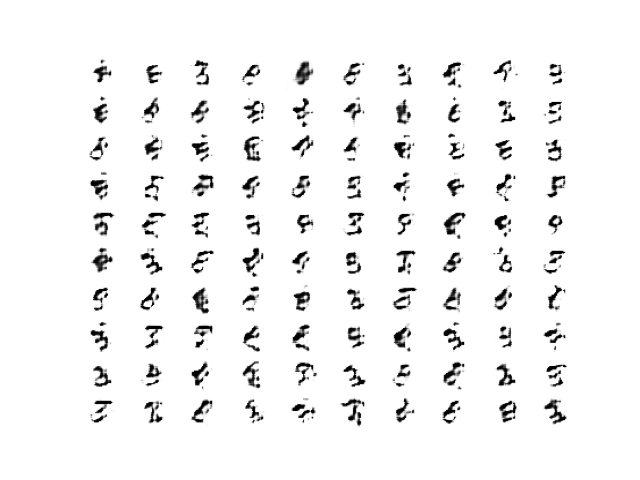

In [25]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
from IPython.display import Image, display

# Load the model
model = load_model('generator_model_005.h5')

# Generate latent points
latent_points = generate_latent_points(10, 500)  # Adjust based on your function
X = model.predict(latent_points)

# Save the plot
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch + 1)
    plt.savefig(filename)
    plt.close()

# Save generated images
save_plot(X, 5)

# Show the saved image
def show_saved_images(epoch):
    filename = f'generated_plot_e{epoch + 1:03d}.png'
    display(Image(filename))

# Display the images
show_saved_images(5)
